In [1]:
from Cameras import Webcam, MachineVision
from Projections import MainScreen
from CaptureSessions import DeflectometryCapture, GradientIlluminationCapture
from Calibrations import RadiometricCalibration, IntrinsicCalibration
from CalibrationsSessions import RadiometricCalibSession, IntrinsicCalibSession
from Reconstructions import DeflectometryReconstruction, GradientShiftingReconstruction
from Visualization import Visualization
import Calibration
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ipywidgets as widgets

%load_ext autoreload
%autoreload 2

spefile module not found
netCDF4 module not found
EdfFile module not found
astropy module not found
olefile module not found


# Set up camera
Set up a camera from the pre-implemented classes or implement your own by creating a new camera class inherenting from the camera base class.

Try out laptop webcam:

In [ ]:
# Internal Webcam
cam = Webcam.Internal()

Preview camera stream (Press enter to end preview): 

In [ ]:
cam.viewCameraStreamJupyter()

Set resolution:

In [ ]:
print(cam.getResolution())

In [ ]:
cam.setResolutionJupyter((640, 480))

In [ ]:
frame = cam.getImage(name='anything', saveImage=False, saveNumpy=False)
print(frame.shape)

In [ ]:
cam.viewCameraStreamJupyter()

In [ ]:
cam.quit_and_close()

Try out USB webcam:

In [ ]:
# External Webcam
cam1 = Webcam.External()

In [ ]:
cam1.viewCameraStreamJupyter()

In [ ]:
cam1.quit_and_close()

Try out Basler Machine Vision:

In [ ]:
# Basler Machine Vision
cam = MachineVision.Basler()

In [ ]:
cam.viewCameraStreamJupyter()

Set exposure:
Adjust the exposure time of the camera to your preference. Exposure time is defined in micro seconds.

In [ ]:
# Set exposure and gain if desire to adjust
#exposure = w.value
exposure = 400000
cam.setExposure(exposure)
# cam.setAutoGain()

In [ ]:
cam.viewCameraStreamJupyter()

In [ ]:
cam.quit_and_close()

Other cameras:

In [ ]:
#cam = NoCamera.NoCamera()
#cam = Raspberry.RaspberryCam()

# Set up projector
Set up a projector from the pre-implemented classes or implement your own by creating a new projector class inherenting from the projector base class. The default projector is set-up as the main screen of your compuputer. Adjust your main screen in your computer settings if you want to use an external monitor or a projector.
- Macintosh: https://support.apple.com/en-us/HT202351
- Windows: https://support.microsoft.com/en-us/windows/how-to-use-multiple-monitors-in-windows-10-329c6962-5a4d-b481-7baa-bec9671f728a

In [ ]:
# Set-up your projector
projection = MainScreen.Screen()

# Intrinsic Calibration

Initialize with default DINA4 ChArUco Boarda:
- Visit: https://calib.io/pages/camera-calibration-pattern-generator
- Select: Board width: 279 mm  Board height: 215 mm - Rows: 8 - Columns: 11 - Marker width: 24 mm - Circle: 4 mm 
- Create and print: calib.io_charuco_279x215_8x11_24_DICT_4X4.pdf

In [ ]:
# Set up the calibration object
# Default parameters are for the aforementioned and printed ChArUco board
intr_calib = IntrinsicCalibration.IntrinsicCalibration()

- Initialize a capture session that will open a video stream and take an image after pressing the return key. After video stream closes, takes an image and opens again for you to alternate the viewing perspective (translation & rotation), while having the board visible at all times.
- <span style='color:Red'> To stop the current stream and take an image press return key. OpenCV does not support clicking on X to close the window.  </span>

In [ ]:
# Set up the calibration session by passing on the camera and the calibration object
intr_calib_session = IntrinsicCalibSession.IntrinsicCalibSession(cam, intr_calib)

In [ ]:
cam.viewCameraStreamJupyter()

In [ ]:
# Capture images for calibration
#intr_calib_session.capture()

In [ ]:
# Compute calibration and save results in CalibrationNumpyData/intrinsic_calibration.npz
# Saved are ret: Rep Error, mtx:Camera Matrix, dist: Distortion Coefficients, rvecs: Rotation vectors, tvecs: Translation vectors
#intr_calib_session.calibrate()

In [ ]:
intr_calib.load_calibration_data()

# Radiometric Calibration

<div>
<img src="CalibrationImages/Colorchecker.png" width=400/>
<img src="CalibrationImages/colorgrad.png" width=500/>
</div>

Opposed to intrinsic and geometric calibration - radiometric calibration does not depend on the use of a calibration object. Instead radiometric calibration tries to find the camera specific response function by taking a set of images of the same scene captured under different exposures into account. Just a brief summary about setting the camera exposure:
- High exposure will capture the scene radiance for a longer amount of time -> good for dark image setting -> bad for motion
- Low exposure will capture the scene radiance for a shorter amount of time -> good for bright image setting -> good for motion




Therefore if we will change the exposure time of the camera, we also have to make sure that we acquire images under a setting which allows us to observe information at different exposures. This is called high dynamic range and it is the motivation behind HDR imaging. So when do we need HDR? Correct, when there is bright parts of the image as well as dark parts. A simple example of this would be to look outside from a corridor in a building, the parts of the image in the building will be in a much darker setting than outside. With this in mind wisely choose a scene that represents a high dynamic range to acquire a good fit for the camera response.




In [ ]:
# Set up the calibration object
radio_calib = RadiometricCalibration.RadiometricCalibration(cam.getResolution())

In [ ]:
# Set up the calibration session by passing on the camera and the calibration object
# To set your own exposures please pass them to the RadiometricCalibSession when creating
radio_calib_session = RadiometricCalibSession.RadiometricCalibSession(cam, radio_calib)

In [ ]:
# Capture images at different exposures
#radio_calib_session.capture()

In [ ]:
# Calibrate for camera response function (g function)
#g, g_n = radio_calib_session.calibrate_HDR(smoothness=500)

In [ ]:
radio_calib.load_calibration_data()

In [ ]:
radio_calib.plotCurve('Grayscale')

# Extrinsic calibration

## Glue the markers

Before you take a picture for extrinsic calibrration, you need to print and glue aruco markers on the mirror (used for calibration) and/or object you would like to reconstruct. Placing those markers in right order on right positions are crutial to high-precision reconstruction. Please read the guideline carefully and glue markers following guideline!
    
In our precedure, we assume the mirror and object are rectangular. So we recommend using rectangular mirror. If your object is not rectangular (e.g. a round-shape object), you can place the object on a rectangular board and place markers on the board.


The markers are in file *6x6_40mm.pdf* in the folder 'Calibration images'. Make sure that this file is printed without any scaling. Each markers should be 50*50mm (with edges). Then place the markers as is shown in the following figure

After intrinsic calibration, you need to do a geometric/extrinsic calibration. The purpose of geometric calibration is to calculate pose, i.e. rotation and translation between object, camera and display. 

When doing geometric calibration, you need the image of the mirror, with reflected checkerboard from display (both original and undistorted). Also, you need to know the dimension of the mirror and the size of checkersquare on the screen. After the geometric calibration program, you can see the visualized mirror, camera and display in a world coordinate system. If everything works on well, you should see them placed at similar positions as they are placed in the real-world.

In [ ]:
g_calib = GeometricCalibration.GeometricCalibration(cam, projection)

Create a geometric calibration session:

In [ ]:
geo_calib_session = GeometricCalibSession.GeometricCalibSession(cam, projection, g_calib)

Capture image of screen projecting checkerboard on the mirror:

In [ ]:
#geoCalib.capture()

Undistort the captured image:

In [ ]:
intr_calib.undistort_images(imgFolder='CalibrationImages/Geometric')

In [ ]:
g_cal.calibrate('CalibrationImages/Geometric/capture_0.PNG')

# Gradient Illumination Capture and Reconstruction

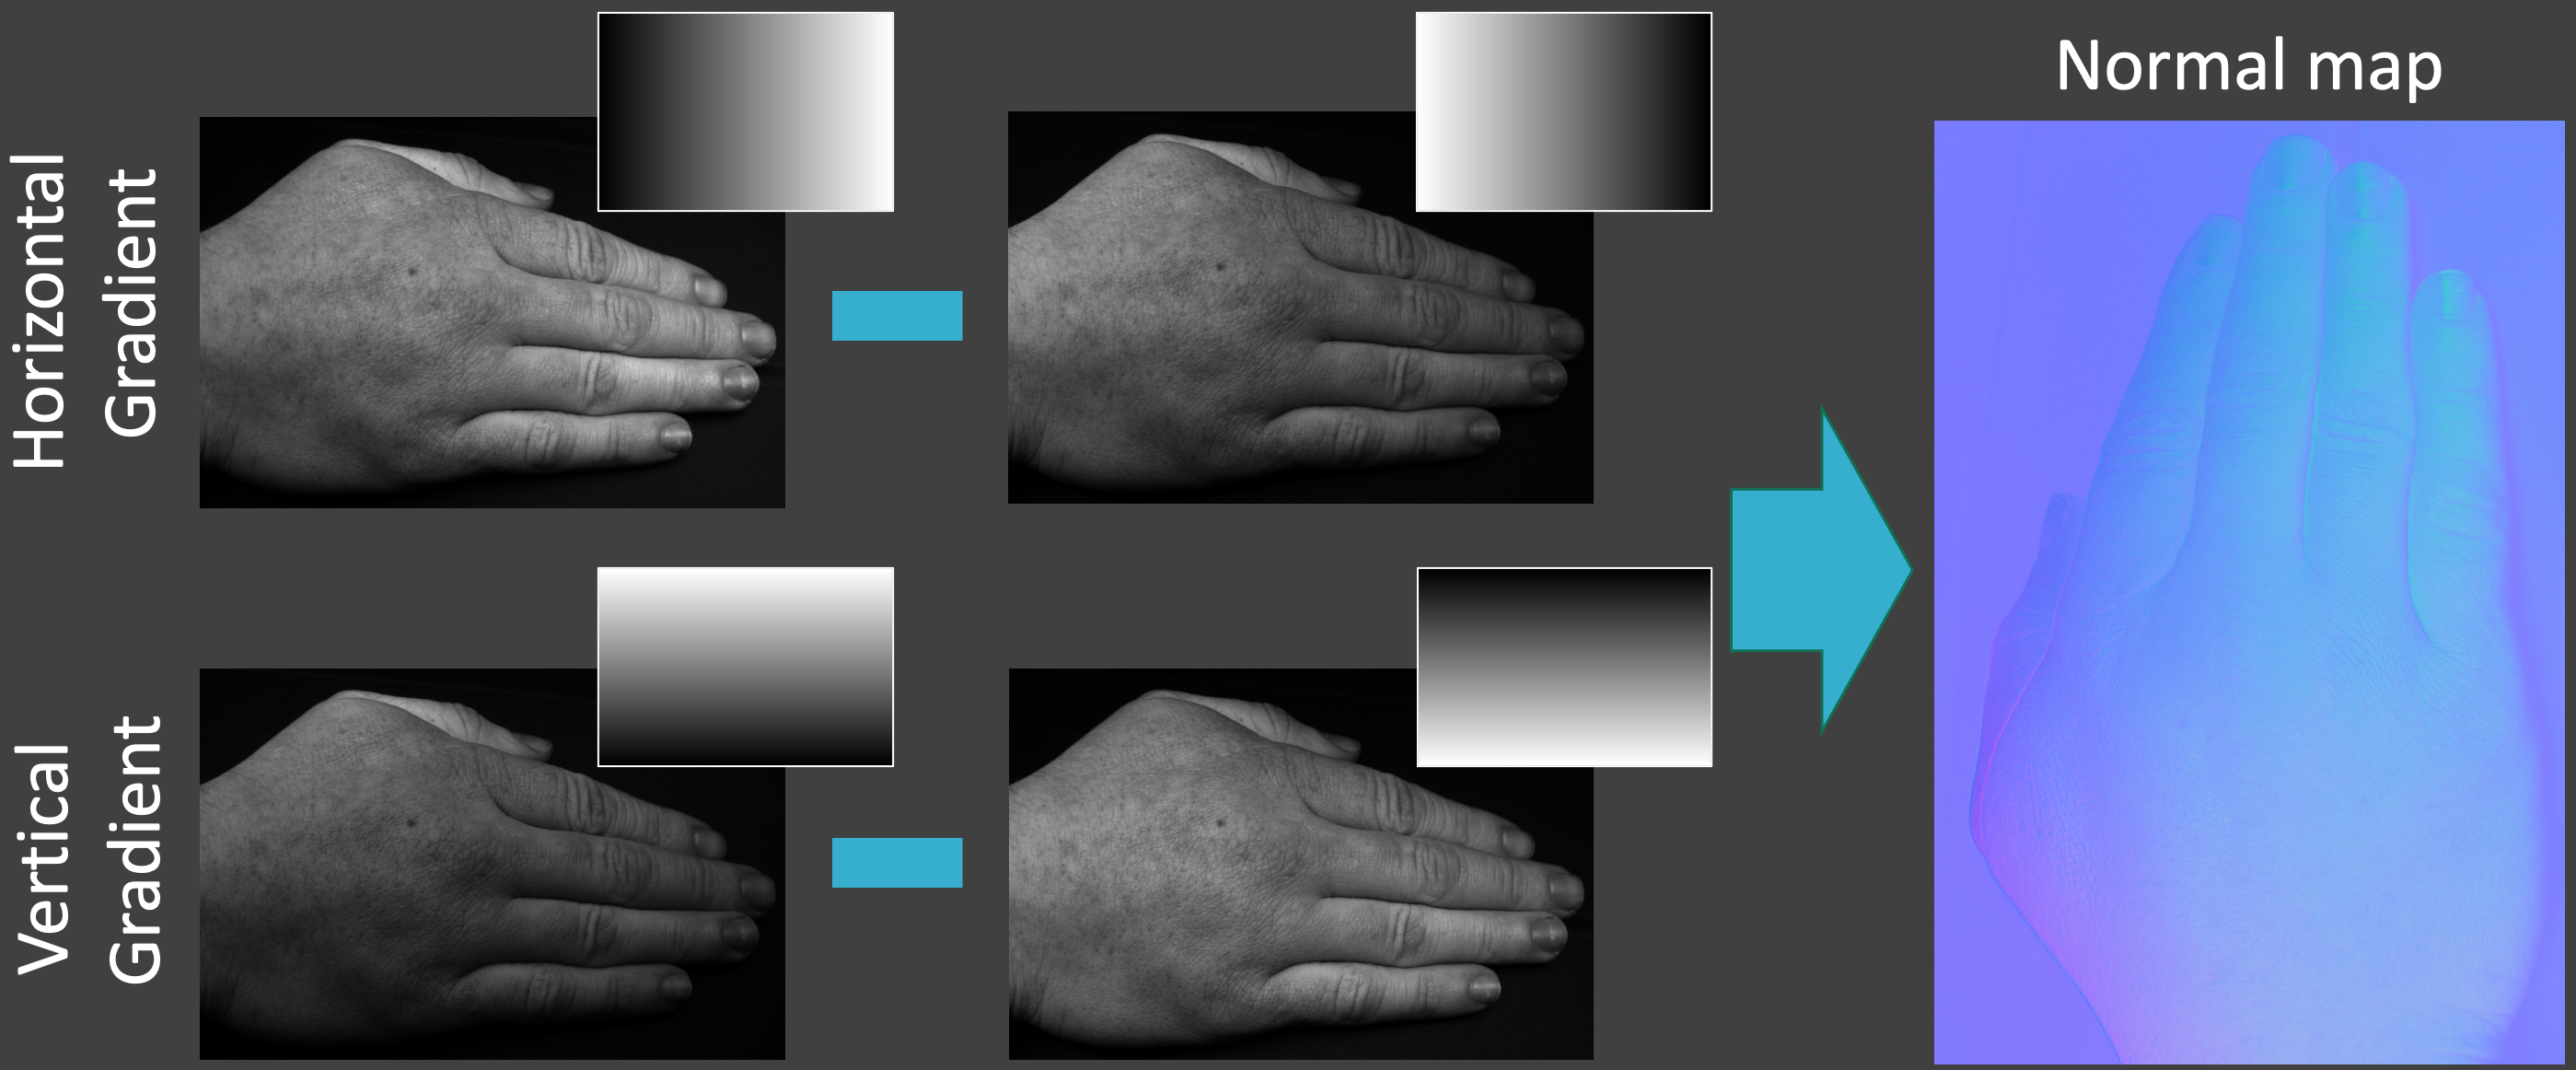

## Set up reconstruction and capture method
Set up the reconstruction/image processing object

In [ ]:
# Number of patterns to display in each direction e.g npg=2 -> 2 x X Pattern & 2 x Y Pattern
nph = 2
# Set up image processing/reconstruction
image_processing = GradientShiftingReconstruction.GradientShiftingReconstruction(n=nph)
#image_processing = DeflectometryReconstruction.DeflectometryReconstruction(nph=nph)

Capture mode to use with camera and projector (e.g. gradients for Gradient Illumination, sinusoids for Deflectometry...)

In [ ]:
# Set up your capture session
cap = GradientIlluminationCapture.GradientIlluminationCapture(cam, projection, image_processing, n=nph)
#cap = DeflectometryCapture.DeflectometryCapture(cam, projection, image_processing, nph=nph)

Set calibration object:

In [ ]:
calib = Calibration.Calibration(radio_calib=radio_calib, intr_calib=intr_calib, geo_calib=geo_calib)
cap.calibrate(calib)

In [ ]:
cam.viewCameraStreamJupyter()

Start the capture: project patterns and take images. Adjust RGB pattern details.

In [ ]:
# Capture images and adjust parts of RGB to display
print("Capturing...")
cap.capture(red=1.0, blue=1.0, green=1.0)

In [ ]:
cam.quit_and_close()

Compute normals and albedo map:

In [ ]:
# Compute results
print("Computing...")
cap.compute()

Compute depth map, point cloud, mesh object:

In [ ]:
# Compute mesh object saved in /MeshObject
# Crop to specific reason to minimize error and computation time:
# Tuples to crop: ((X_start, X_width), (Y_start, Y_height))
#image_processing.computePointCloud(((650, 250), (700, 300)))

## Visualization

In [ ]:
# Visualize results by creating a visualization object passing on the image processing object
vis = Visualization(cap.image_processing)
#vis.showPhaseMaps()
vis.showAlbedo()
vis.showAllImages()
vis.showNormals()
#vis.showQuiverNormals(stride=30)
#image_processing.saveTiff()